# Inspect Buildings Training Data

Inspect and visualize data loading and pre-processing code.

In [86]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa
from skimage.exposure import rescale_intensity 

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/buildings"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))
    
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import buildings

%matplotlib inline 

In [87]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

## Configurations

In [88]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/buildings")

# Use configuation from buildings.py, but override
# image resizing so we see the real sizes here
class NoResizeConfig(buildings.BuildingsConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

## Notebook Preferences

In [89]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Download the dataset from the competition Website. Unzip it and save it in `mask_rcnn/datasets/nucleus`. If you prefer a different directory then change the `DATASET_DIR` variable above.

https://www.kaggle.com/c/data-science-bowl-2018/data

In [90]:
# Load dataset
dataset = buildings.BuildingsDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
dataset.load_dataset(os.path.join(DATASET_DIR, "val"), load_small=True)

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Annotation Path  /home/munshkr/dym/Mask_RCNN/datasets/buildings/val/annotation-small.json
Image Dir  /home/munshkr/dym/Mask_RCNN/datasets/buildings/val/images
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Image Count: 1820
Class Count: 2
  0. BG                                                
  1. building                                          


## Display Samples

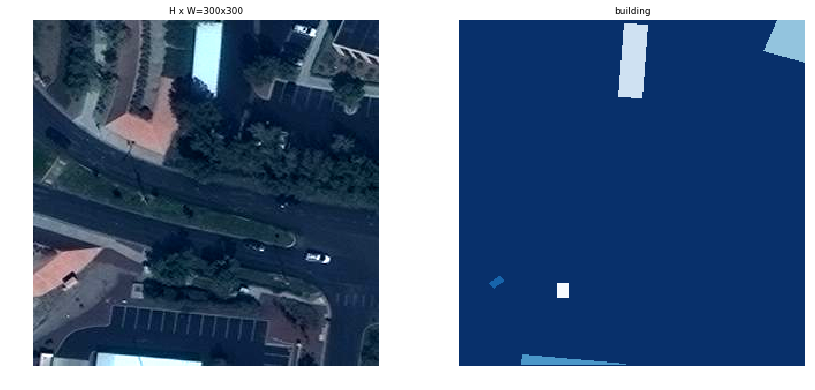

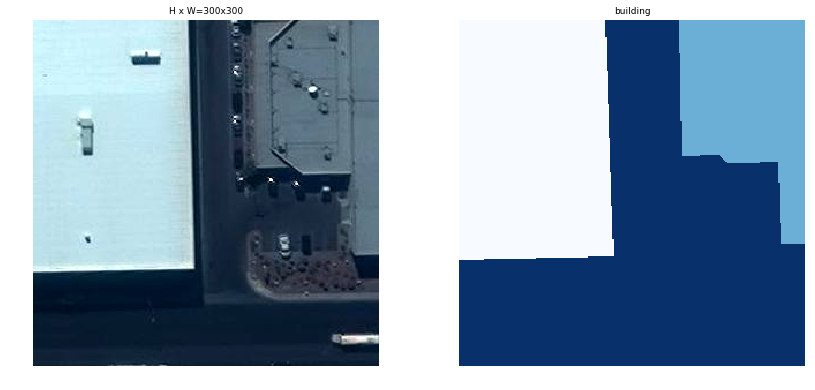

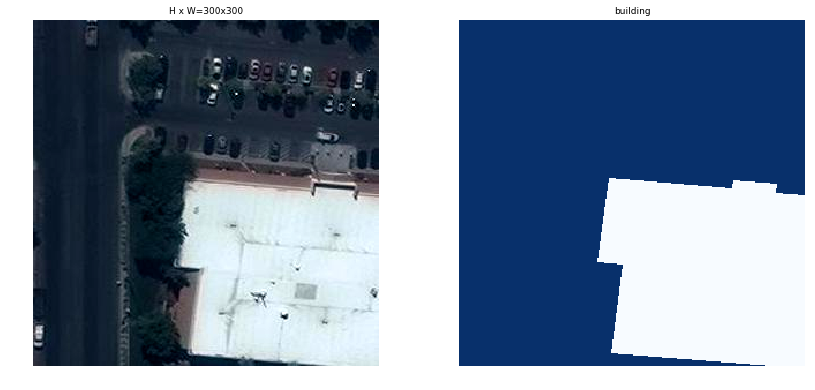

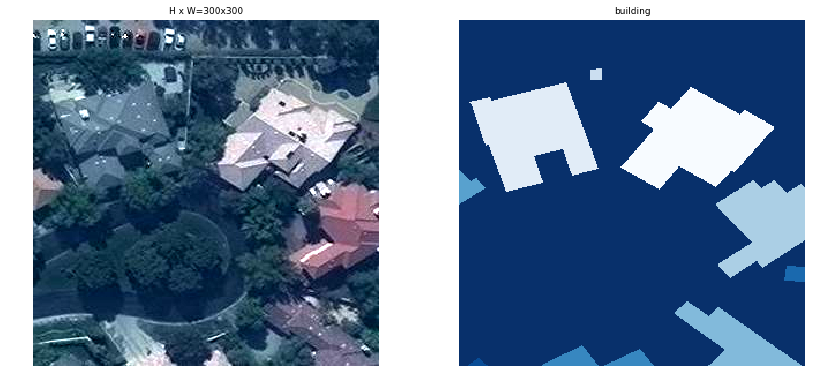

In [98]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    low, high = np.percentile(image, (2, 99))
    new_image = rescale_intensity(image, in_range=(low, high))
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(new_image, mask, class_ids, dataset.class_names, limit=1)

molded_image             shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (300, 300, 8)         min:    0.00000  max:    1.00000  uint8


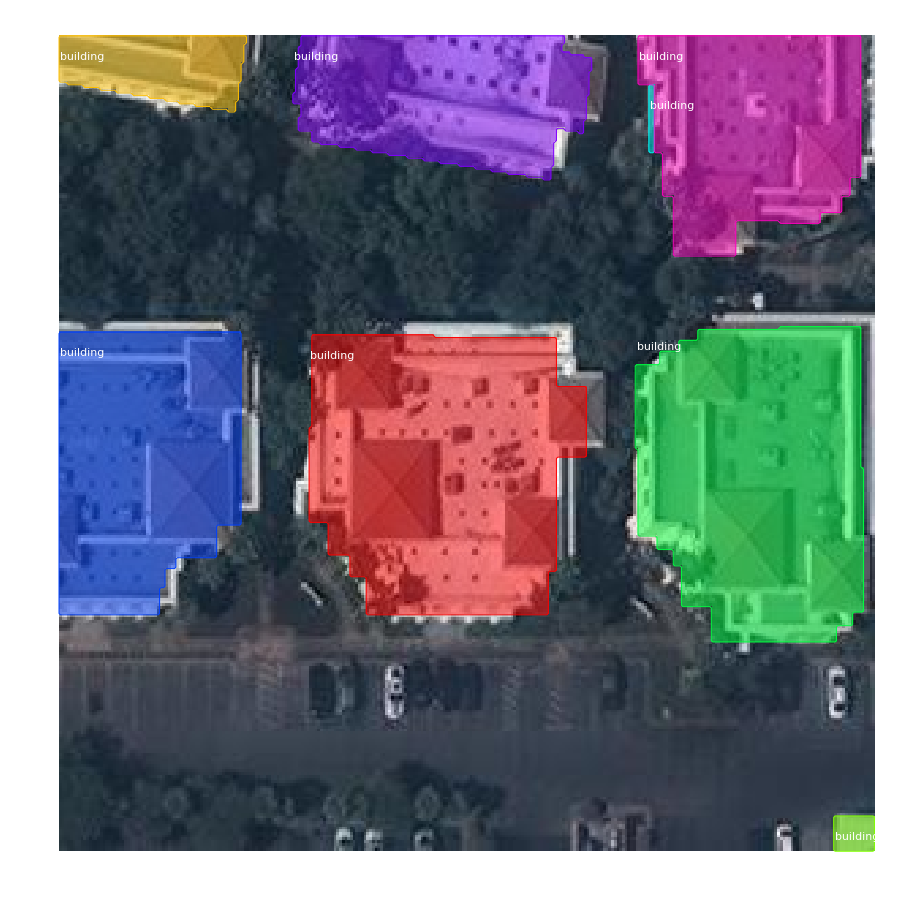

In [99]:
# Example of loading a specific image by its source ID
source_id = "39335"

# Map source ID to Dataset image_id
# Notice the buildings prefix: it's the name given to the dataset in BuildingsDataset
image_id = dataset.image_from_source_map["crowdai-mapping-challenge.{}".format(source_id)]

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False)

## Dataset Stats

Loop through all images in the dataset and collect aggregate stats.

In [28]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    #assert mask.shape[:2] == image.shape[:2], "[{}] mask.shape[:2] == {}, image.shape[:2] == {}".format(image_id, mask.shape[:2], image.shape[:2])
    # Skip images with invalid masks (?)
    if mask.shape[:2] != image.shape[:2]:
        return
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
print("Total images: {}".format(len(stats)))
stats = [s for s in stats if s]
print("Total images after filtering: {}".format(len(stats)))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total images: 1820
Total images after filtering: 1820
Total time: 10.3 seconds


### Image Size Stats

In this case, CrowdAI dataset is already cropped to 300x300 tiles.

Image Count:  1820
Height  mean: 300.00  median: 300.00  min: 300.00  max: 300.00
Width   mean: 300.00  median: 300.00  min: 300.00  max: 300.00
Color   mean (RGB): 76.83 88.74 100.46


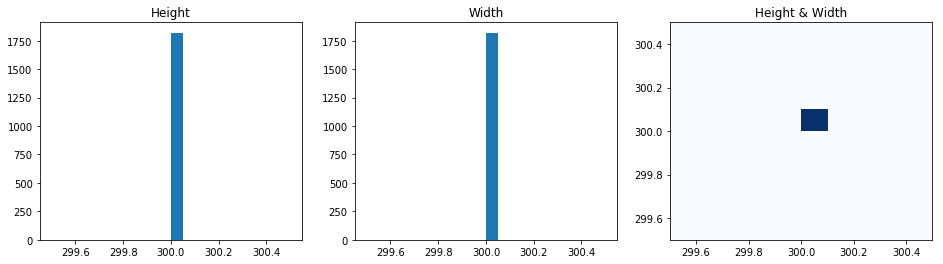

In [33]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

### Building per Image Stats

Building/Image
Image area <=  300**2:  mean: 8.6  median: 8.0  min: 1.0  max: 33.0


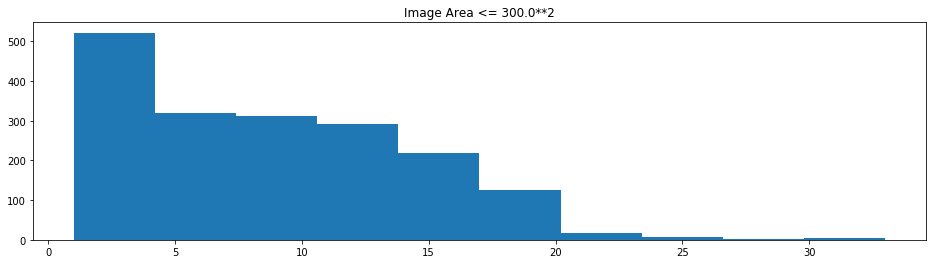

In [58]:
# Segment by image area
image_area_bins = [300**2]

print("Building/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
if len(image_area_bins) == 1:
    ax = np.array([ax])
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    building_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area])
    area_threshold = image_area
    if len(building_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), building_per_image.mean(), np.median(building_per_image), 
        building_per_image.min(), building_per_image.max()))
    ax[i].set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax[i].hist(building_per_image, bins=10)

### Building Size Stats


Image Area <= 300**2
  Total Buildings:  15640
  Building Height. mean: 49.19  median: 47.00  min: 1.00  max: 300.00
  Building Width.  mean: 49.47  median: 47.00  min: 1.00  max: 300.00
  Building Area.   mean: 3090.77  median: 2135.00  min: 1.00  max: 90000.00


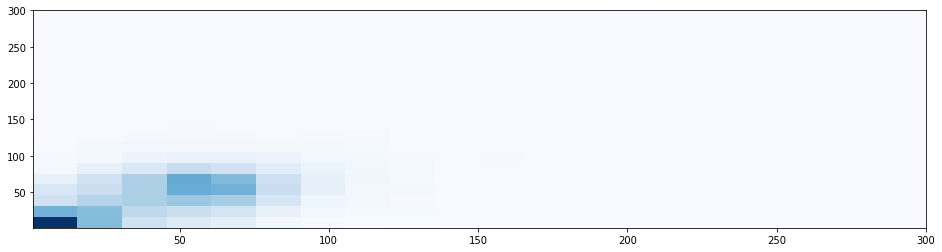

In [59]:
# Nuclei size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
if len(image_area_bins) == 1:
    ax = np.array([ax])
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    building_shape = np.array([
        b 
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    building_area = building_shape[:, 0] * building_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Buildings: ", building_shape.shape[0])
    print("  Building Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(building_shape[:, 0]), np.median(building_shape[:, 0]),
        np.min(building_shape[:, 0]), np.max(building_shape[:, 0])))
    print("  Building Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(building_shape[:, 1]), np.median(building_shape[:, 1]),
        np.min(building_shape[:, 1]), np.max(building_shape[:, 1])))
    print("  Building Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(building_area), np.median(building_area),
        np.min(building_area), np.max(building_area)))

    # Show 2D histogram
    _ = ax[i].hist2d(building_shape[:, 1], building_shape[:, 0], bins=20, cmap="Blues")

Building Aspect Ratio.  mean: 1.55  median: 1.00  min: 0.02  max: 113.00


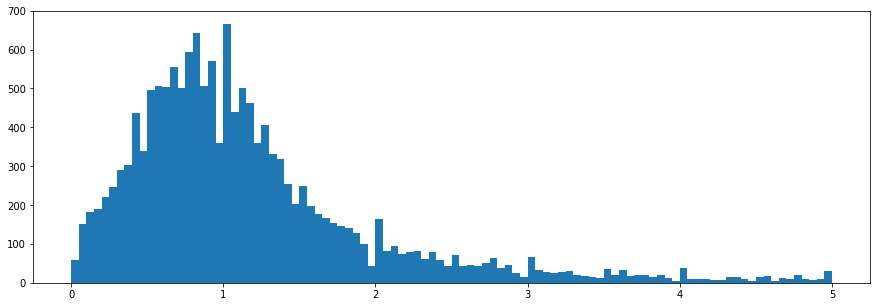

In [60]:
# Buildings height/width ratio
building_aspect_ratio = building_shape[:, 0] / building_shape[:, 1]
print("Building Aspect Ratio.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(building_aspect_ratio), np.median(building_aspect_ratio),
    np.min(building_aspect_ratio), np.max(building_aspect_ratio)))
plt.figure(figsize=(15, 5))
_ = plt.hist(building_aspect_ratio, bins=100, range=[0, 5])

## Image Augmentation

Test out different augmentation methods

In [63]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 3.0))
])

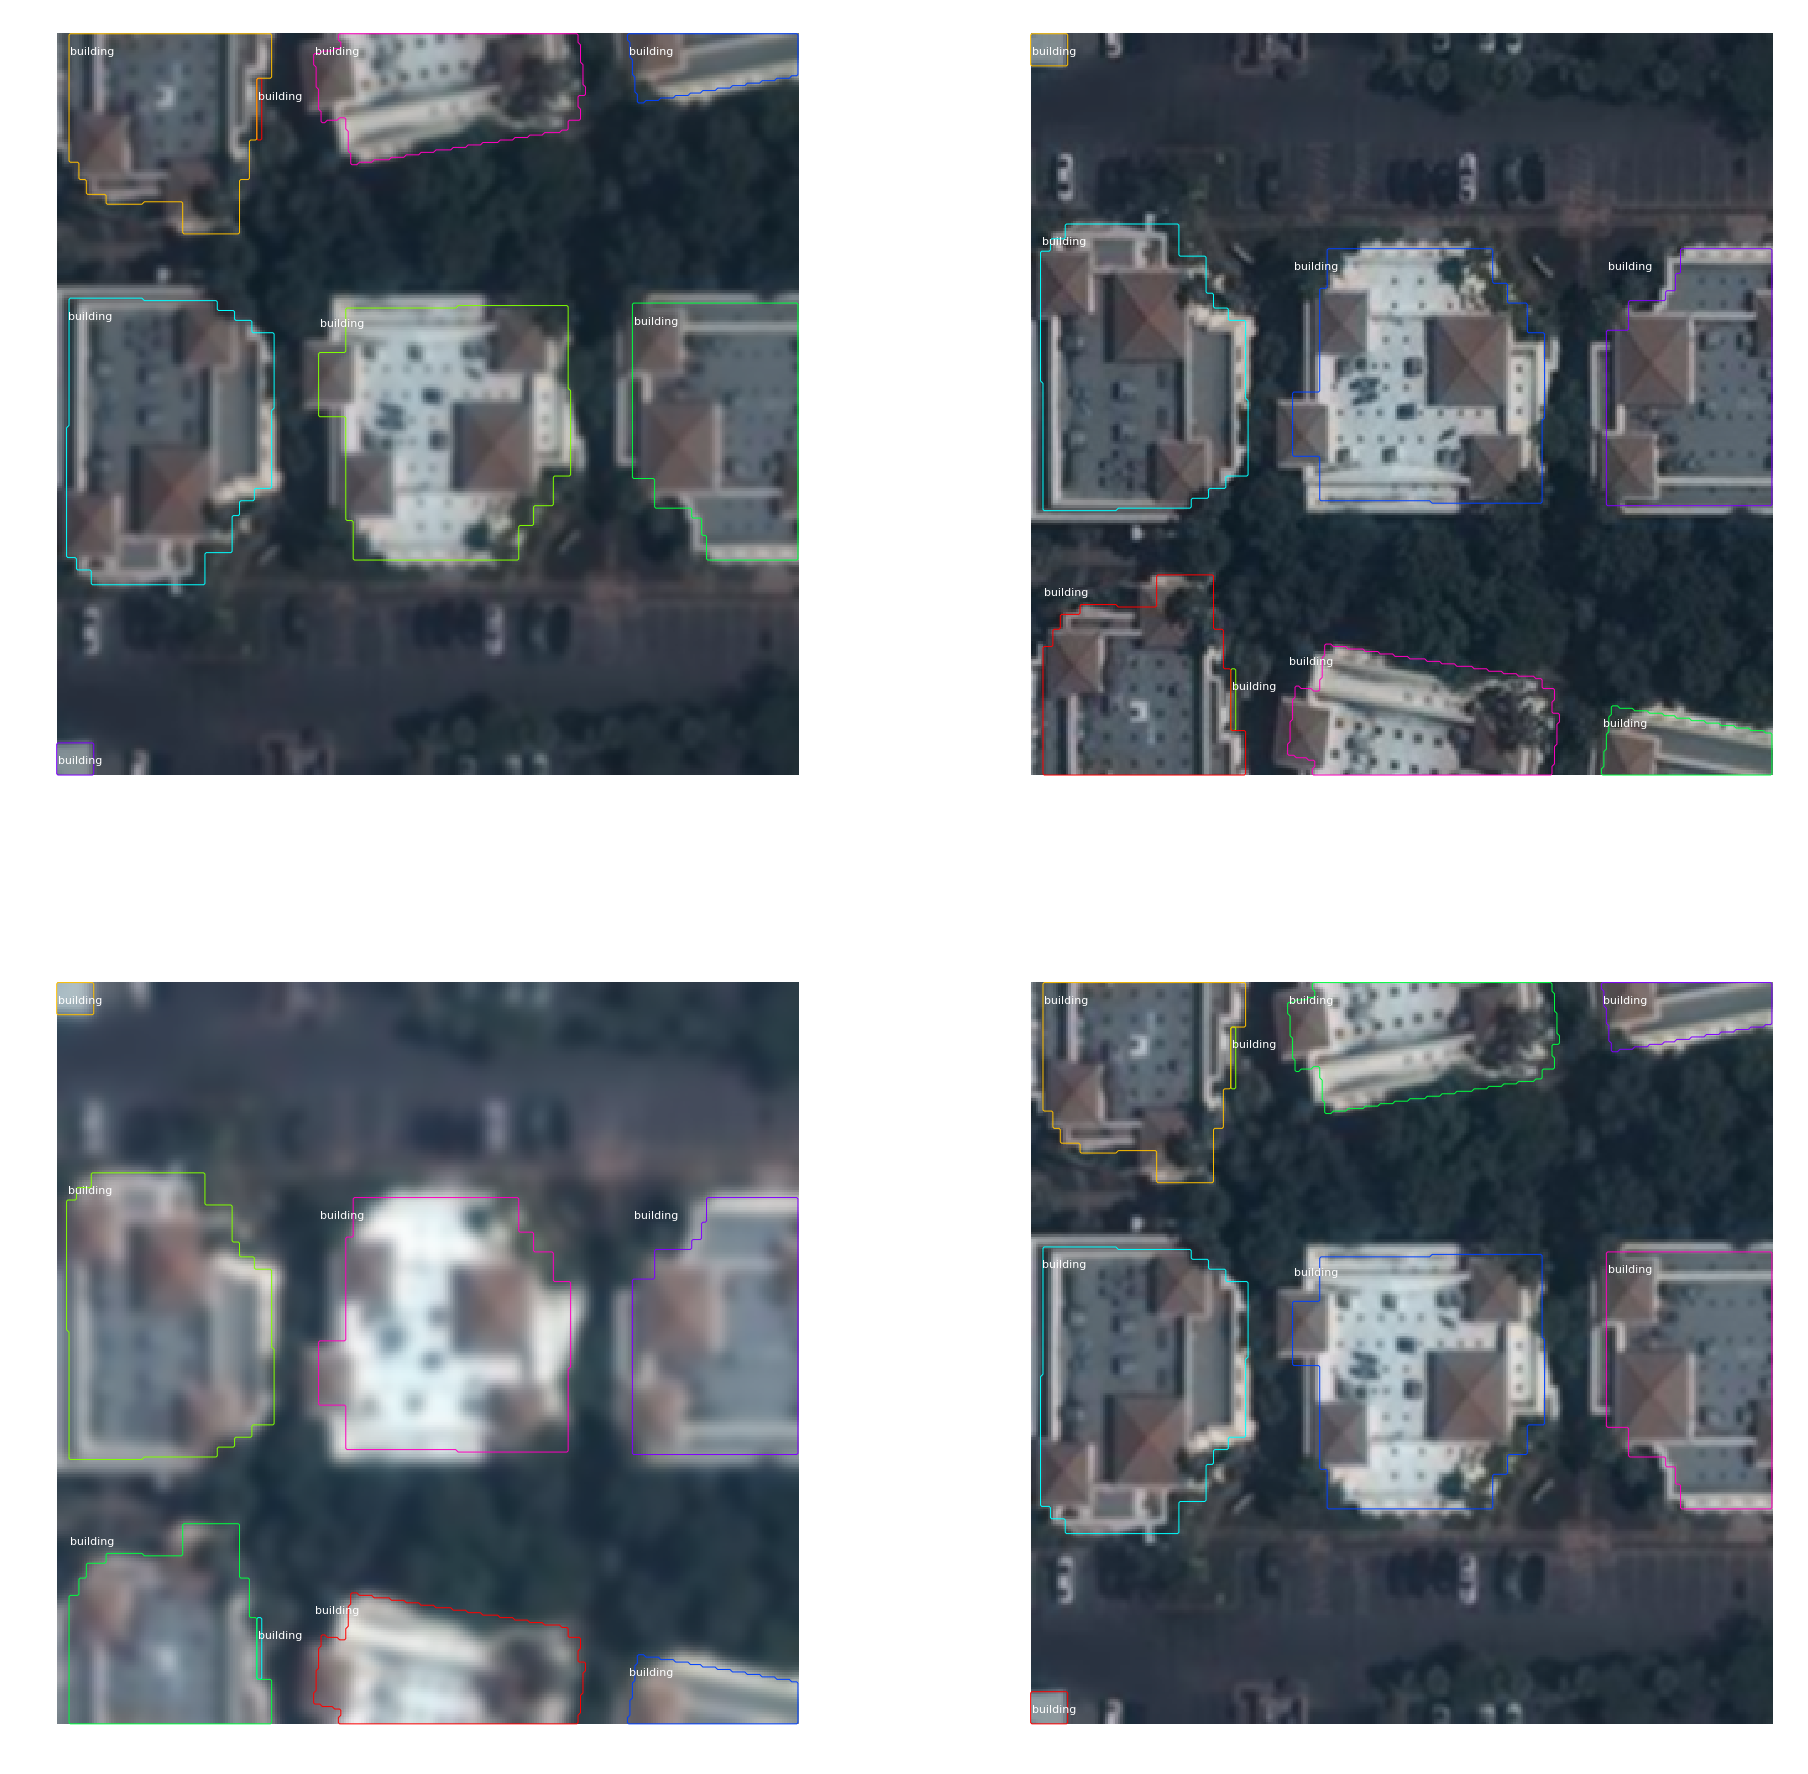

In [64]:
# Load the image multiple times to show augmentations
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Image Crops

Microscoy images tend to be large, but nuclei are small. So it's more efficient to train on random crops from large images. This is handled by `config.IMAGE_RESIZE_MODE = "crop"`.



In [70]:
class RandomCropConfig(buildings.BuildingsConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

crop_config = RandomCropConfig()

/home/munshkr/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/munshkr/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/munshkr/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/munshkr/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing

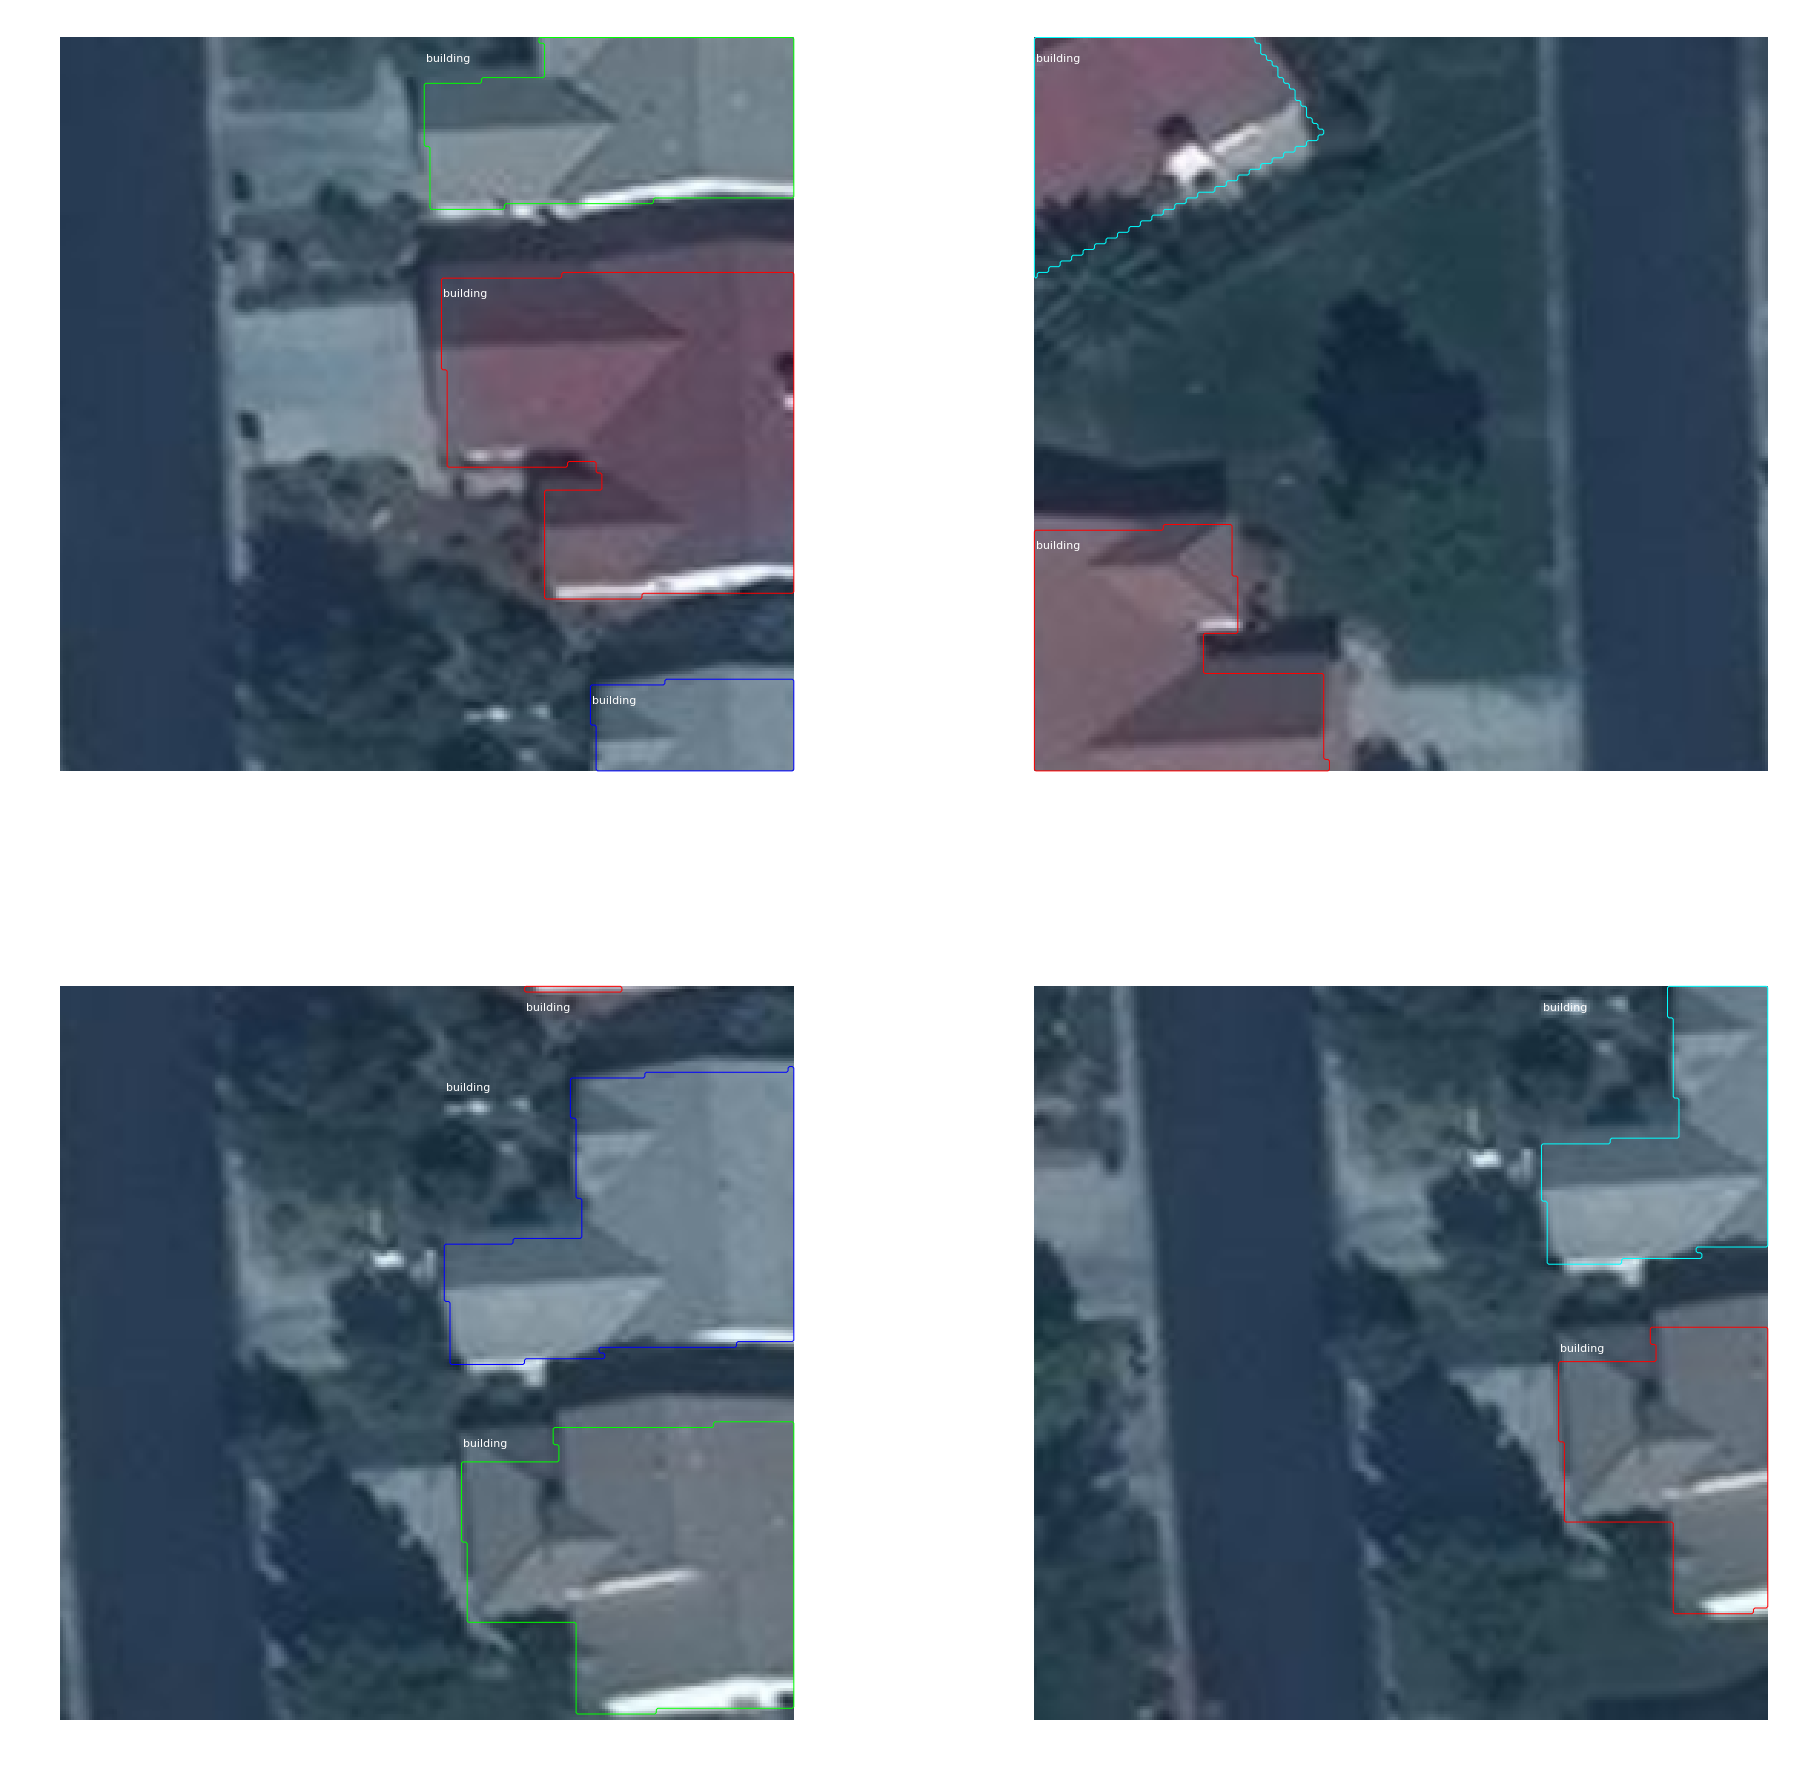

In [71]:
# Load the image multiple times to show augmentations
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, crop_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image_id:  38 crowdai-mapping-challenge::38
Original shape:  (300, 300, 3)
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (300, 300, 8)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (8,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (8, 4)                min:    0.00000  max:  300.00000  int32


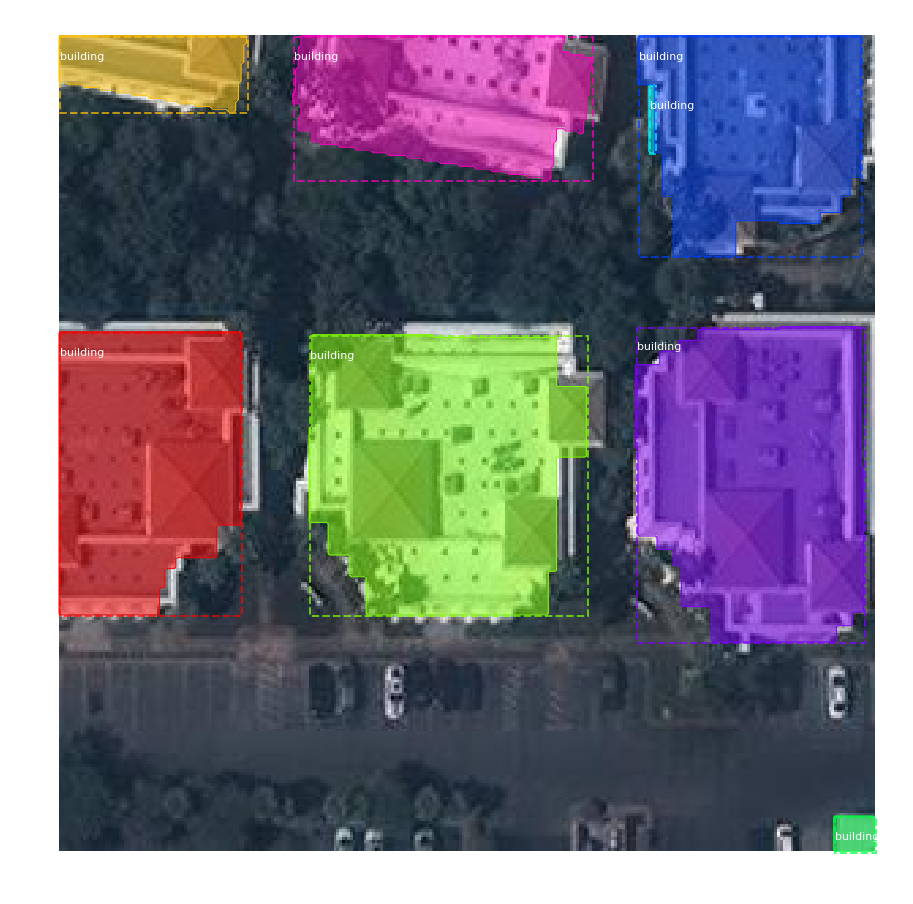

In [72]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  830.00000  int64
class_ids                shape: (12,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (12, 4)               min:    0.00000  max:  300.00000  int32
mask                     shape: (300, 300, 12)        min:    0.00000  max:    1.00000  uint8


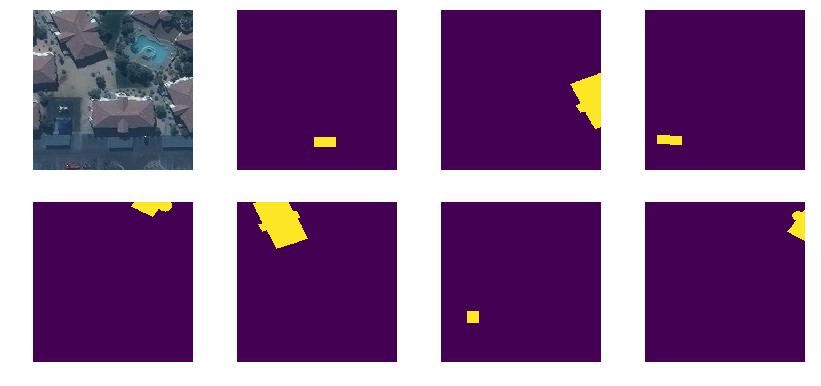

In [73]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

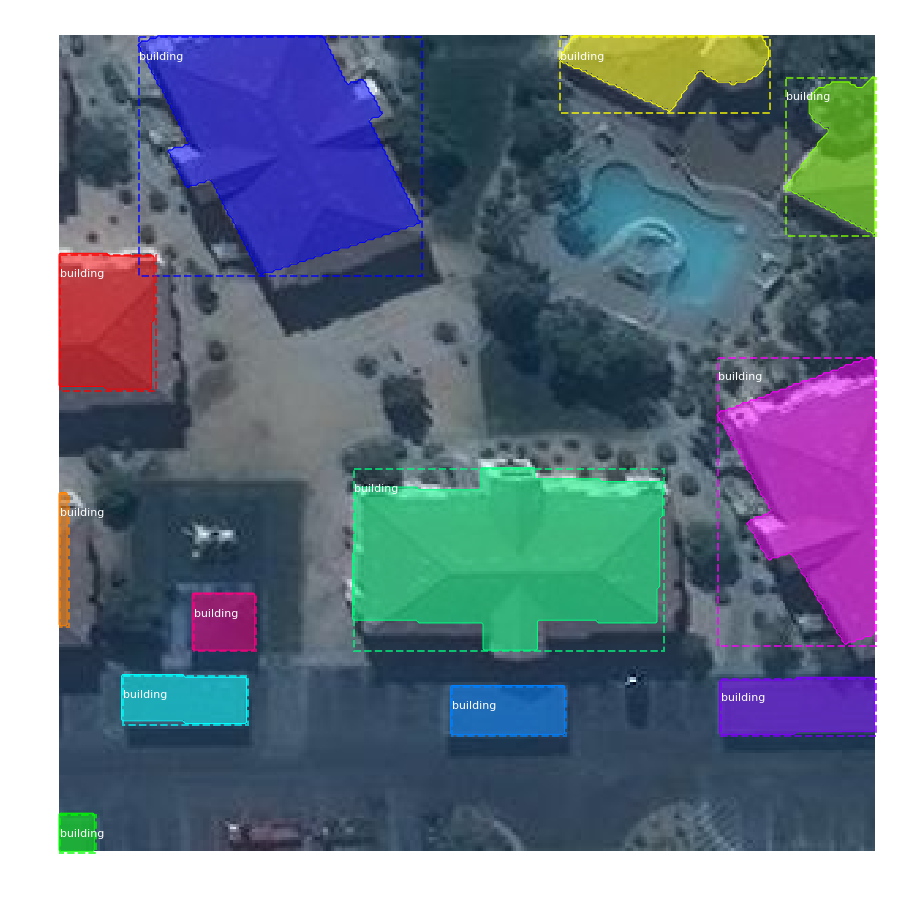

In [74]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

/home/munshkr/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


mask                     shape: (56, 56, 12)          min:    0.00000  max:    1.00000  bool


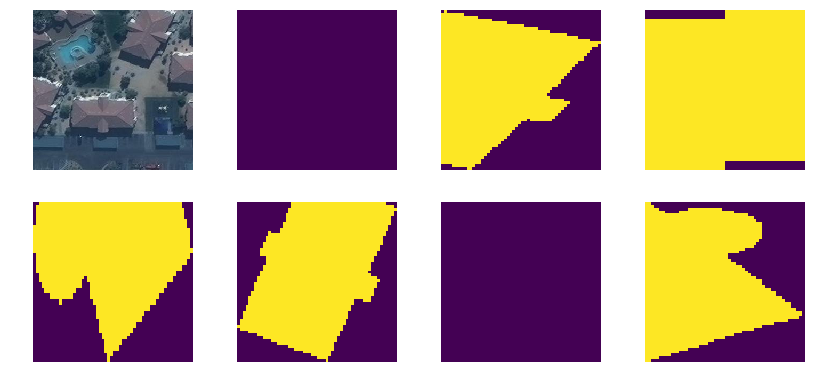

In [75]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

/home/munshkr/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


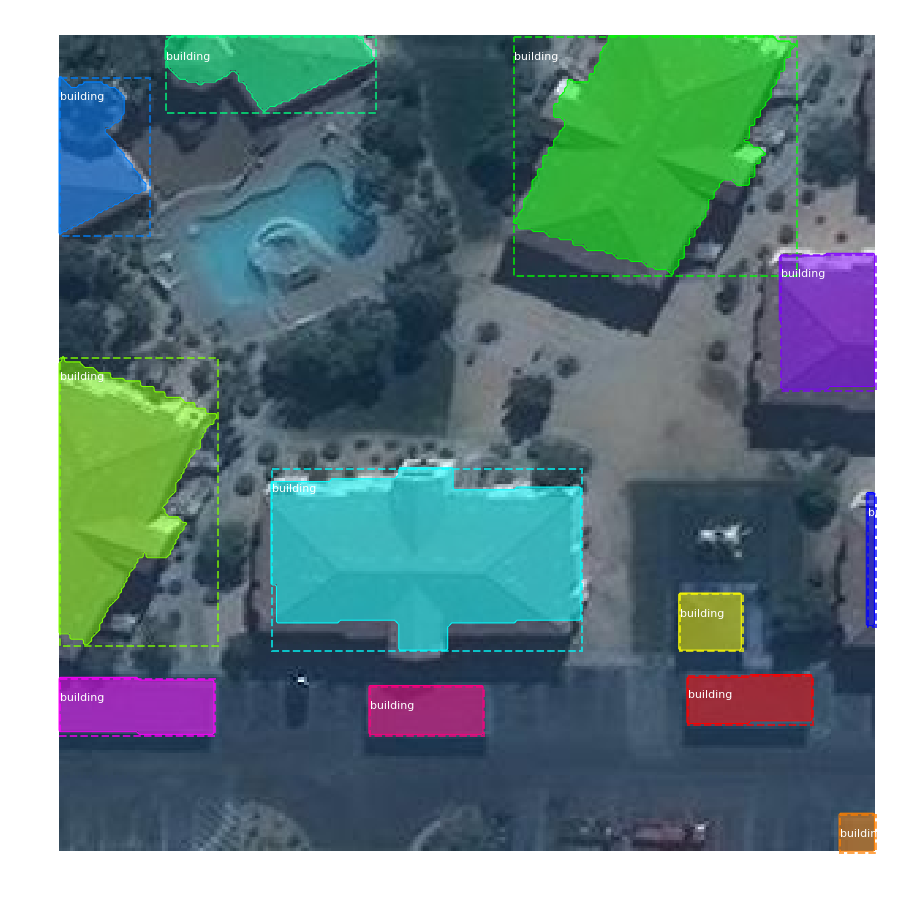

In [76]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

Count:  22665
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 16875
Anchors in Level 1: 4332
Anchors in Level 2: 1083
Anchors in Level 3: 300
Anchors in Level 4: 75
Level 0. Anchors:  16875  Feature map Shape: [75 75]
Level 1. Anchors:   4332  Feature map Shape: [38 38]
Level 2. Anchors:   1083  Feature map Shape: [19 19]
Level 3. Anchors:    300  Feature map Shape: [10 10]
Level 4. Anchors:     75  Feature map Shape: [5 5]


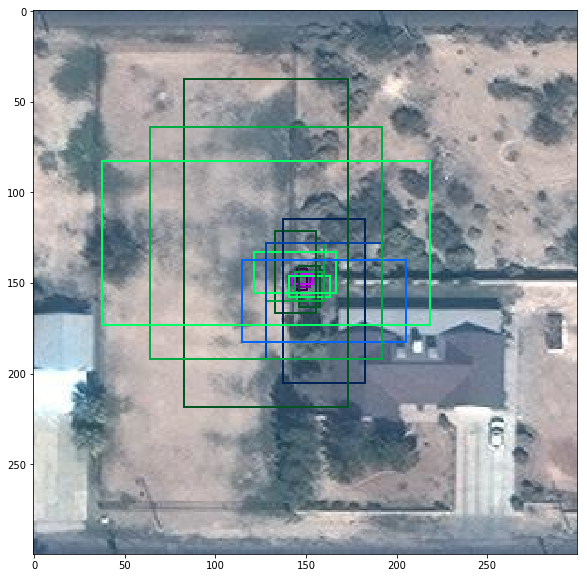

In [79]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)
